Cell 1: Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from statsmodels.tsa.arima.model import ARIMAResults
from tensorflow.keras.models import load_model

# Load combined data CSV or reload data however you had it before
# Example: If you saved combined_df previously, load it or recreate here
# For now, assuming you have combined_df in memory or loaded


Cell 2: Load your saved models and scaler.

In [4]:
# Load saved ARIMA model
arima_model = ARIMAResults.load("../models/arima_model.pkl")

# Load saved scaler for LSTM data preprocessing
scaler = joblib.load("../models/scaler.pkl")

# Load saved LSTM model
lstm_model = load_model("../models/lstm_model.keras")


c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Cell 3: Prepare your Tesla stock data for forecasting — extract the 'Close' prices for TSLA, sorted by date, and split into train and test sets.

Cell 3b to download and create combined_df again

In [7]:
import yfinance as yf
import pandas as pd

tickers = ['TSLA', 'BND', 'SPY']
start = '2015-07-01'
end = '2025-07-31'

all_data = {}

for ticker in tickers:
    print(f"Downloading {ticker} data...")
    df = yf.download(ticker, start=start, end=end, auto_adjust=False)
    df.ffill(inplace=True)  # Fill missing data
    df['Ticker'] = ticker
    all_data[ticker] = df

combined_df = pd.concat(all_data.values(), axis=0)
combined_df.index.name = 'Date'

print("Data combined!")


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Data combined!


In [8]:
import pandas as pd

# Load the combined data CSV if needed (or use existing combined_df)
# combined_df = pd.read_csv("../data/your_combined_data.csv", index_col='Date', parse_dates=True)


# Filter TSLA data and use 'Close' price
tsla_data = combined_df[combined_df['Ticker'] == 'TSLA']['Close'].sort_index()

# Define forecast horizon (e.g., 6 months ~ 126 trading days)
horizon_days = 126

# Split into train and test based on horizon_days
train = tsla_data[:-horizon_days]
test = tsla_data[-horizon_days:]


Cell 4 — extract the TSLA closing prices and set up the forecast horizon:

In [9]:
# Extract TSLA Close prices, sorted by date
tsla_data = combined_df[combined_df['Ticker'] == 'TSLA']['Close'].sort_index()

# Define forecast horizon (e.g., 6 months ≈ 126 trading days)
horizon_days = 126

# Split train and test sets (train = all except last horizon_days, test = last horizon_days)
train = tsla_data[:-horizon_days]
test = tsla_data[-horizon_days:]

print(f"Train set length: {len(train)}")
print(f"Test set length: {len(test)}")


Train set length: 2409
Test set length: 126


Cell 5 — generate the ARIMA forecast with confidence intervals

In [10]:
from statsmodels.tsa.arima.model import ARIMAResults

# Load your saved ARIMA model
arima_model = ARIMAResults.load("../models/arima_model.pkl")

# Forecast next 'horizon_days' steps with confidence intervals
arima_forecast_obj = arima_model.get_forecast(steps=horizon_days)
forecast_arima = arima_forecast_obj.predicted_mean
conf_int = arima_forecast_obj.conf_int()

# Print forecast head and confidence intervals shape to verify
print(forecast_arima.head())
print(conf_int.shape)


2140    248.479996
2141    248.479996
2142    248.479996
2143    248.479996
2144    248.479996
Name: predicted_mean, dtype: float64
(126, 2)


c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Cell 6 — LSTM multi-step forecasting with the sliding window approach and inverse scaling:

In [12]:
print(type(train))
print(train.shape)
print(train.head())


<class 'pandas.core.frame.DataFrame'>
(2409, 3)
Ticker           TSLA  BND  SPY
Date                           
2015-07-01  17.943333  NaN  NaN
2015-07-02  18.667999  NaN  NaN
2015-07-06  18.648001  NaN  NaN
2015-07-07  17.858667  NaN  NaN
2015-07-08  16.997334  NaN  NaN


In [14]:
import numpy as np
import pandas as pd

look_back = 60  # Must match LSTM training input window
lstm_forecast_scaled = []

# Take last 'look_back' days from train data and scale it

last_train_values = scaler.transform(train['TSLA'][-look_back:].values.reshape(-1, 1))


# Reshape to (1, look_back, 1) for LSTM input
input_seq = last_train_values.reshape(1, look_back, 1)

for _ in range(horizon_days):
    pred_scaled = lstm_model.predict(input_seq, verbose=0)
    lstm_forecast_scaled.append(pred_scaled[0, 0])

    # Update input sequence: slide window by 1, append latest prediction
    
    input_seq = last_train_values.reshape(1, look_back, 1)


# Inverse transform the scaled predictions back to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1, 1)).flatten()

# Create datetime index for the forecast horizon
lstm_forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=horizon_days, freq='B')
lstm_forecast_series = pd.Series(lstm_forecast, index=lstm_forecast_index)

# Show first few predictions
print(lstm_forecast_series.head())


c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2025-01-29    398.09198
2025-01-30    398.09198
2025-01-31    398.09198
2025-02-03    398.09198
2025-02-04    398.09198
Freq: B, dtype: float32


Cell 7: Generate LSTM multi-step forecast with sliding window

In [16]:
lstm_forecast_scaled = []

for _ in range(horizon_days):
    pred_scaled = lstm_model.predict(input_seq, verbose=0)
    lstm_forecast_scaled.append(pred_scaled[0, 0])
    
    # Slide window: remove oldest value and add newest prediction
    input_seq = np.append(input_seq[:, 1:, :], pred_scaled.reshape(1, 1, 1), axis=1)


# Inverse transform predictions back to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1, 1)).flatten()

# Create datetime index for the forecast horizon
lstm_forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=horizon_days, freq='B')

# Convert to pandas Series for easier plotting
lstm_forecast_series = pd.Series(lstm_forecast, index=lstm_forecast_index)


Cell: Plot historical TSLA prices and forecasts from both ARIMA and LSTM

In [19]:
from statsmodels.tsa.arima.model import ARIMAResults

# Load trained ARIMA model
fitted_model = ARIMAResults.load("../models/arima_model.pkl")


In [22]:
# Assuming 'fitted_model' is your trained ARIMA model

# Forecast for horizon_days steps with confidence intervals
arima_forecast_result = fitted_model.get_forecast(steps=horizon_days)

# Extract forecasted mean and confidence intervals
forecast_arima = arima_forecast_result.predicted_mean
conf_int = arima_forecast_result.conf_int()






c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


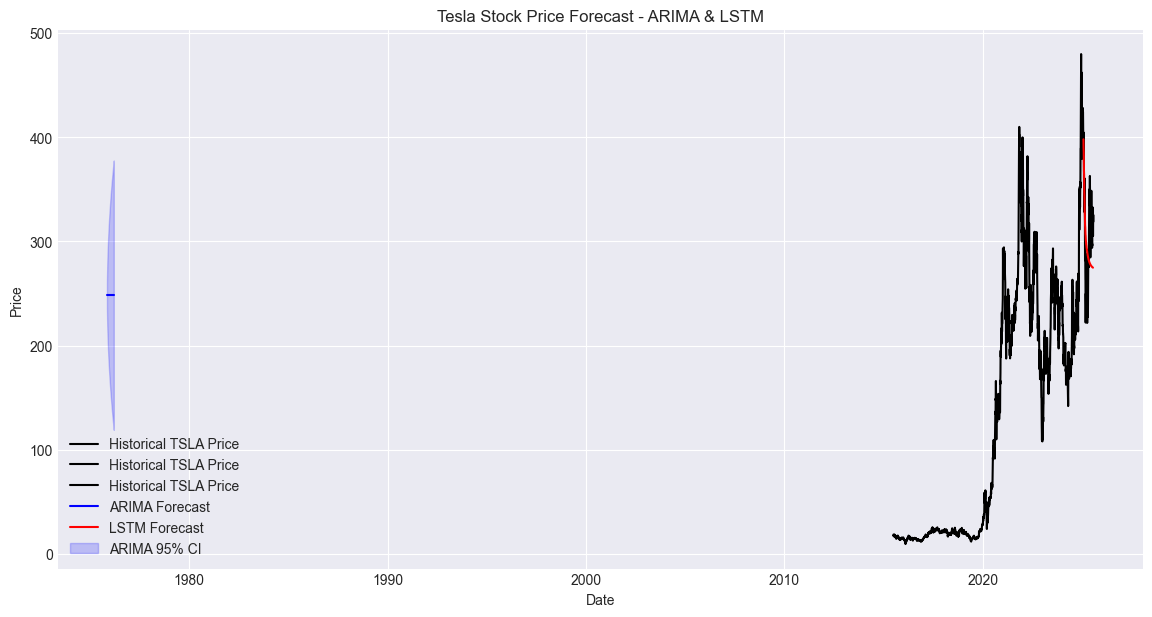

In [24]:
plt.figure(figsize=(14, 7))

# Plot historical actual data
plt.plot(tsla_data.index, tsla_data.values, label='Historical TSLA Price', color='black')

# Plot ARIMA forecast
plt.plot(forecast_arima.index, forecast_arima.values, label='ARIMA Forecast', color='blue')

# Plot LSTM forecast
plt.plot(lstm_forecast_series.index, lstm_forecast_series.values, label='LSTM Forecast', color='red')

# Plot ARIMA confidence intervals (shaded)

plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],  # Lower bound
                 conf_int.iloc[:, 1],  # Upper bound
                 color='blue', alpha=0.2, label='ARIMA 95% CI')


plt.title("Tesla Stock Price Forecast - ARIMA & LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
